In [1]:
import cv2   
import numpy as np   
import matplotlib.pyplot as plt
import imutils
from scipy.spatial import ConvexHull

In [2]:
coordinates = []
def click_event(event, x, y, flags, params):
  
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         cv2.putText(img, str(x) + ',' +
#                     str(y), (x,y), font,
#                     1, (255, 0, 0), 2)
        cv2.imshow('image', img)
        coordinates.append([x,y])
  
    # checking for right mouse clicks     
    if event==cv2.EVENT_RBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         b = img[y, x, 0]
#         g = img[y, x, 1]
#         r = img[y, x, 2]
#         cv2.putText(img, str(b) + ',' +
#                     str(g) + ',' + str(r),
#                     (x,y), font, 1,
#                     (255, 255, 0), 2)
        cv2.imshow('image', img)
        coordinates.append([x,y])

In [3]:
fileName = 'vis_Bakul_002_000970.png'
imgDirPath = '/home/src21/my_project_dir/Drone-based-building-assessment/templateMatching/images/resnet/'
imgPath = imgDirPath + fileName
# Reading the main image   
img = cv2.imread(imgPath,1)
img_show = np.copy(img)
img_copy = np.copy(img)
img_rgb = np.copy(img)

340   4
338   126
498   126
499   3
731   5
725   127
883   129
891   3


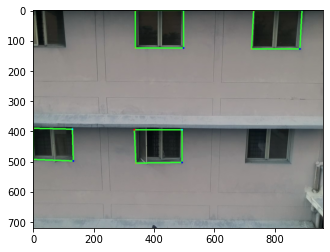

In [4]:
plt.figure()
plt.imshow(img_rgb)
cv2.imshow('image',img_rgb)

# setting mouse hadler for the image
# and calling the click_event() function
cv2.setMouseCallback('image', click_event)

# wait for a key to be pressed to exit
cv2.waitKey(0)

# close the window
cv2.destroyAllWindows()

In [5]:
#print(coordinates)
#coordinates = coordinates[0:2]
print(coordinates)
print("\n")

coords = np.array(coordinates)
coords = np.reshape(coords,(coords.shape[0]//4 , 4, coords.shape[1]))
print(coords)
print(coords[0])


[[340, 4], [338, 126], [498, 126], [499, 3], [731, 5], [725, 127], [883, 129], [891, 3]]


[[[340   4]
  [338 126]
  [498 126]
  [499   3]]

 [[731   5]
  [725 127]
  [883 129]
  [891   3]]]
[[340   4]
 [338 126]
 [498 126]
 [499   3]]


In [6]:
# Loop through list to find range of x and y

def calculateRange(coordinates, padding, imageShape):
    minX = maxX = coordinates[0][0]
    minY = maxY = coordinates[0][1]
    startX = startY = endX = endY = 0
    h,w,c = imageShape
    for i in range(len(coordinates)):
        if minX > coordinates[i][0]:
            minX = coordinates[i][0]
        if maxX < coordinates[i][0]:
            maxX = coordinates[i][0]

        if minY > coordinates[i][1]:
            minY = coordinates[i][1]
        if maxY < coordinates[i][1]:
            maxY = coordinates[i][1]
    
    if (minX - padding < 0):
        startX = 0
    else:
        startX = minX - padding
    if (minY - padding < 0):
        startY = 0
    else:
        startY = minY - padding
    if (maxX + padding >= w):
        endX = w - 1
    else:
        endX = maxX + padding
    if (maxY + padding >= h):
        endY = h - 1
    else:
        endY = maxY + padding
    return startX, endX, startY, endY

In [7]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [8]:
def mapCoordsToOriginalFrame(coords, searchImgCoords):
    mappedCoords = []
    startX, endX, startY, endY = searchImgCoords
    
    for i in range(len(coords)):
        mappedCoords.append((coords[i][0], coords[i][1] + startY, coords[i][2], coords[i][3] + startY))
    return mappedCoords

def template_plot(template,searchImg,fileName,figname):
    plt.figure(num=figname, figsize=(20,10))
    plt.subplot(1, 2, 2)
    plt.imshow(template)
    plt.title('template_' + str(fileName))     
    plt.subplot(1, 2, 1)
    plt.imshow(searchImg)
    plt.title('templateMatched_' + str(fileName)) 
    plt.show()


In [9]:
def matchTemplate(tW_all, tH_all, rects_all, ind, coordinates, img_rgb, fileName, padding=10):    
    
    startX, endX, startY, endY = calculateRange(coordinates, padding, img_rgb.shape)
    plt.imshow(img_rgb)
    #print(startX, endX, startY, endY)
    #print(img_rgb.shape)
    
    template = img_rgb[startY:endY, startX:endX, :]
    searchImg = img_rgb[startY:endY, : ,:]
    searchImg_copy = np.copy(searchImg)

    template_plot(template,searchImg,fileName,fileName)
    
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)   
    searchImg_gray = cv2.cvtColor(searchImg, cv2.COLOR_BGR2GRAY)
    
    rects = []
    for i in [-2.5, 0, 2.5]:
        # Apply rotation and shear to template
        rotatedTemplate = imutils.rotate(template, i)
        plt.imshow(rotatedTemplate)
        plt.title('rotatedTemplate_' + str(fileName)) 

        template_gray = cv2.cvtColor(rotatedTemplate, cv2.COLOR_BGR2GRAY)   

        # Store width in variable w and height in variable h of template  
        tW, tH = template_gray.shape[::-1]   
        # Now we perform match operations.   
        res = cv2.matchTemplate(searchImg_gray,template_gray,cv2.TM_CCOEFF_NORMED)   
        # Declare a threshold   
        threshold = 0.550
        # Store the coordinates of matched region in a numpy array   
        loc = np.where( res >= threshold)
        print(loc)
        # Draw a rectangle around the matched region.   
        for pt in zip(*loc[::-1]): 
            #print('x: ' + str(pt[0]) + ' y: ' + str(pt[1]))
            cv2.rectangle(searchImg, pt, (pt[0] + tW, pt[1] + tH), (255,0,0), 1)   
            rects.append((pt[0], pt[1], pt[0] + tW, pt[1] + tH))

    # Now display the final matched template image
    plt.figure(num=ind)
    plt.imshow(searchImg)  
    plt.title('Result on search Image')
    plt.show()

    #cv2.imwrite('Template_' +  '0.6_threshold_' + fileName, template)
    #cv2.imwrite('TemplateMatched_'  + '0.6_threshold_' + fileName, searchImg)

    #print(np.array(rects).shape)    
    print(rects)
    #for i in range(len(rects)):
    #    print(rects[i][0])
        
    searchImgCoords = startX, endX, startY, endY
    print("rects: " + str(rects))
    print("\n")
    mappedCoords = mapCoordsToOriginalFrame(rects, searchImgCoords)
    print("mappedCoords: " + str(mappedCoords))

    for pt in (mappedCoords): 
        print(str(pt[0]) + " "  + str(pt[1]))
        print(str(pt[2]) + " "  + str(pt[3]))
        cv2.rectangle(img_show, (pt[0],pt[1]),  (pt[2], pt[3]), (255,0,0), 1)   
    
    print(mappedCoords[0][0])
    # Now display the final matched template image   
    plt.figure(num = 'mapped' + fileName, figsize=(20,10))
    plt.imshow(img_show)  
    plt.title('Final Result')

    tW_new = tW * np.ones(len(mappedCoords),dtype=int)
    tH_new = tH * np.ones(len(mappedCoords),dtype=int)
    
    rects_all.append(mappedCoords)
    tW_all.append(tW_new)
    tH_all.append(tH_new)
    
    return tW_all, tH_all, rects_all


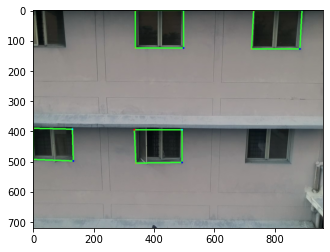

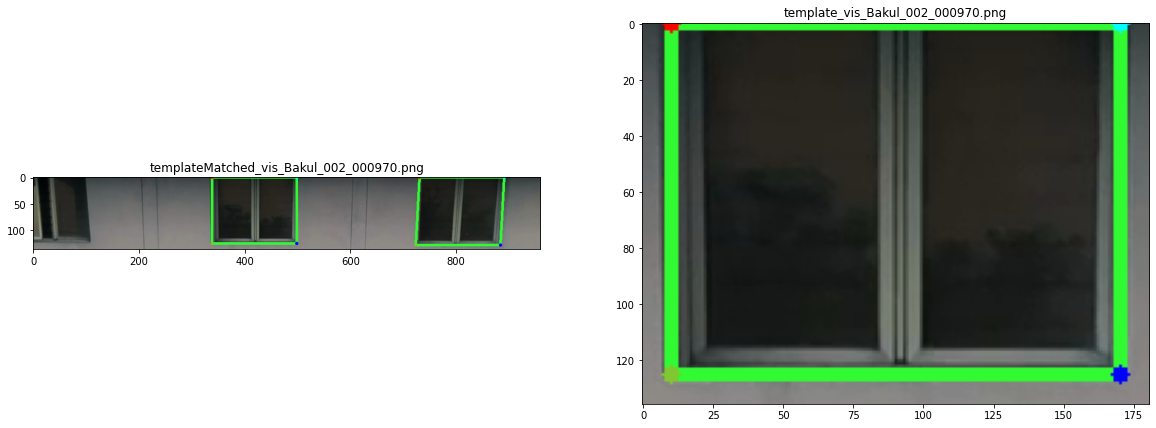

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 333, 334, 335, 336, 337, 338, 705, 706, 707, 708, 709, 710,
       711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 715, 716, 717, 718]))
(array([0, 0, 0, 0, 0, 0]), array([326, 327, 328, 329, 330, 331]))


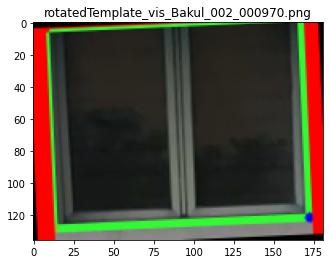

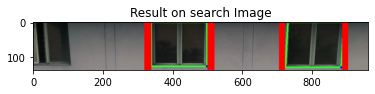

[(319, 0, 500, 136), (320, 0, 501, 136), (321, 0, 502, 136), (322, 0, 503, 136), (323, 0, 504, 136), (324, 0, 505, 136), (325, 0, 506, 136), (326, 0, 507, 136), (327, 0, 508, 136), (328, 0, 509, 136), (329, 0, 510, 136), (330, 0, 511, 136), (331, 0, 512, 136), (332, 0, 513, 136), (333, 0, 514, 136), (334, 0, 515, 136), (335, 0, 516, 136), (336, 0, 517, 136), (337, 0, 518, 136), (338, 0, 519, 136), (705, 0, 886, 136), (706, 0, 887, 136), (707, 0, 888, 136), (708, 0, 889, 136), (709, 0, 890, 136), (710, 0, 891, 136), (711, 0, 892, 136), (712, 0, 893, 136), (713, 0, 894, 136), (714, 0, 895, 136), (715, 0, 896, 136), (716, 0, 897, 136), (717, 0, 898, 136), (718, 0, 899, 136), (719, 0, 900, 136), (720, 0, 901, 136), (721, 0, 902, 136), (324, 0, 505, 136), (325, 0, 506, 136), (326, 0, 507, 136), (327, 0, 508, 136), (328, 0, 509, 136), (329, 0, 510, 136), (330, 0, 511, 136), (331, 0, 512, 136), (332, 0, 513, 136), (333, 0, 514, 136), (334, 0, 515, 136), (335, 0, 516, 136), (336, 0, 517, 136),

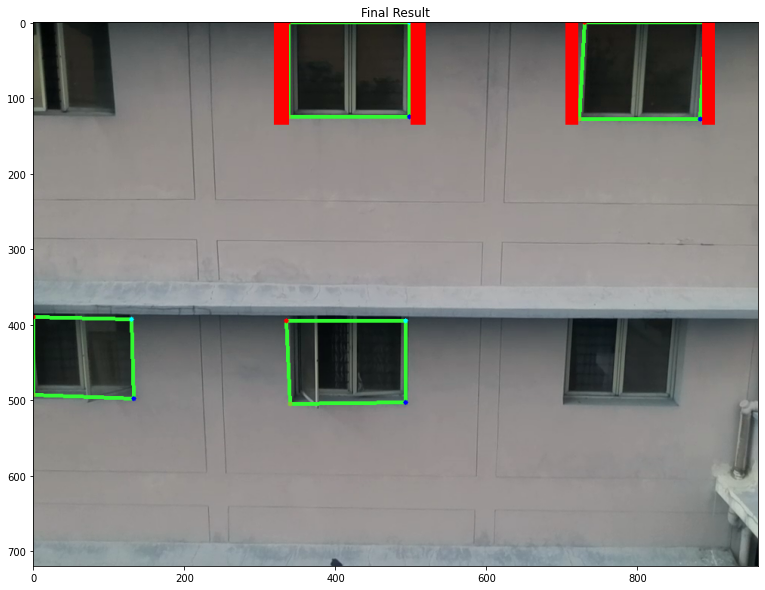

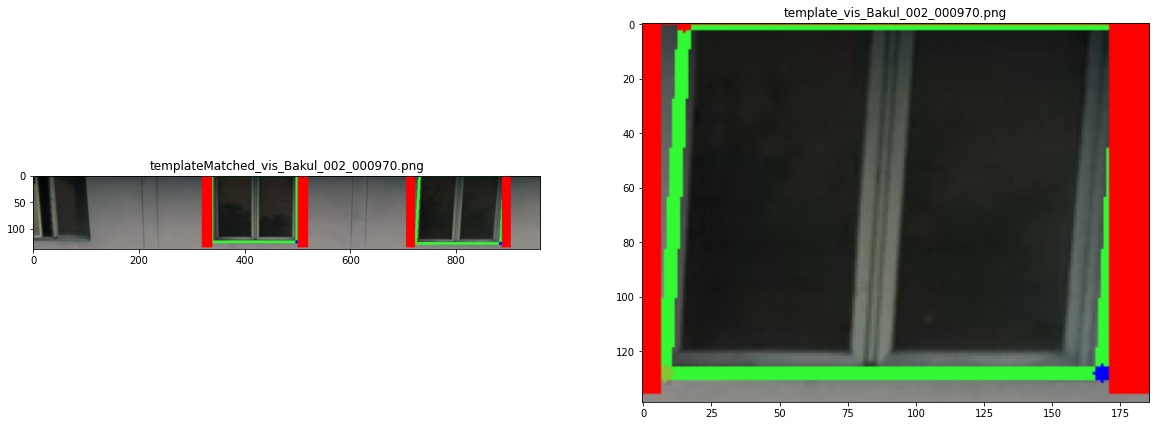

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([327, 328, 329, 330, 331, 332, 333, 334, 335, 710, 711, 712, 713,
       714, 715, 716, 717, 718, 719, 720]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0]), array([324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717,
       718, 719, 720, 721, 722]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 710, 711, 712,
       713, 714, 715, 716, 717, 718, 719]))


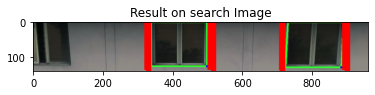

[(327, 0, 513, 139), (328, 0, 514, 139), (329, 0, 515, 139), (330, 0, 516, 139), (331, 0, 517, 139), (332, 0, 518, 139), (333, 0, 519, 139), (334, 0, 520, 139), (335, 0, 521, 139), (710, 0, 896, 139), (711, 0, 897, 139), (712, 0, 898, 139), (713, 0, 899, 139), (714, 0, 900, 139), (715, 0, 901, 139), (716, 0, 902, 139), (717, 0, 903, 139), (718, 0, 904, 139), (719, 0, 905, 139), (720, 0, 906, 139), (324, 0, 510, 139), (325, 0, 511, 139), (326, 0, 512, 139), (327, 0, 513, 139), (328, 0, 514, 139), (329, 0, 515, 139), (330, 0, 516, 139), (331, 0, 517, 139), (332, 0, 518, 139), (333, 0, 519, 139), (334, 0, 520, 139), (335, 0, 521, 139), (336, 0, 522, 139), (337, 0, 523, 139), (338, 0, 524, 139), (707, 0, 893, 139), (708, 0, 894, 139), (709, 0, 895, 139), (710, 0, 896, 139), (711, 0, 897, 139), (712, 0, 898, 139), (713, 0, 899, 139), (714, 0, 900, 139), (715, 0, 901, 139), (716, 0, 902, 139), (717, 0, 903, 139), (718, 0, 904, 139), (719, 0, 905, 139), (720, 0, 906, 139), (721, 0, 907, 139),

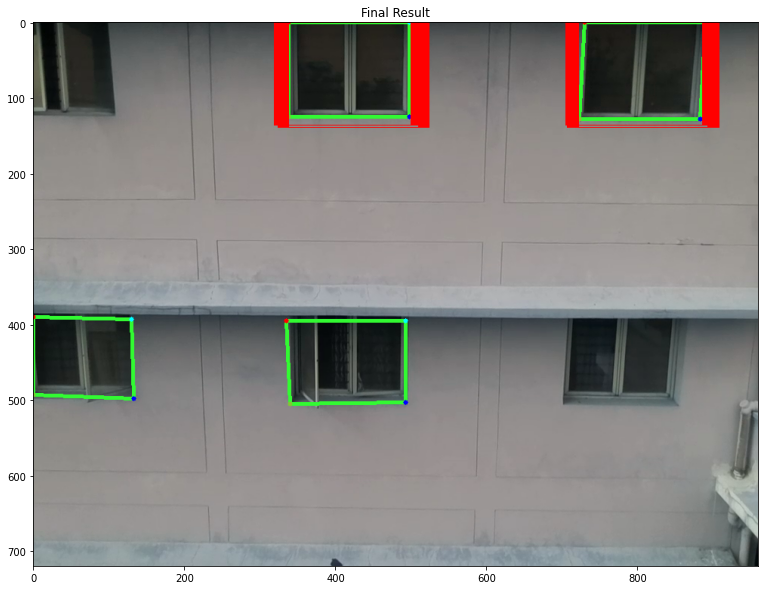

In [10]:
rects_all = []
tW_all = []
tH_all = []

#tW_all, tH_all, rects_all = matchTemplate(tW_all, tH_all, rects_all, 1, coords[0], img_rgb, fileName, padding=10)
for ind in range(coords.shape[0]):
    tW_all, tH_all, rects_all = matchTemplate(tW_all, tH_all, rects_all, ind, coords[ind], img_rgb, fileName, padding=10)

/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/home/src21/my_project_dir/my_project_env/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


[[319   0 500 136]
 [320   0 501 136]
 [321   0 502 136]
 [322   0 503 136]
 [323   0 504 136]
 [324   0 505 136]
 [325   0 506 136]
 [326   0 507 136]
 [327   0 508 136]
 [328   0 509 136]
 [329   0 510 136]
 [330   0 511 136]
 [331   0 512 136]
 [332   0 513 136]
 [333   0 514 136]
 [334   0 515 136]
 [335   0 516 136]
 [336   0 517 136]
 [337   0 518 136]
 [338   0 519 136]
 [705   0 886 136]
 [706   0 887 136]
 [707   0 888 136]
 [708   0 889 136]
 [709   0 890 136]
 [710   0 891 136]
 [711   0 892 136]
 [712   0 893 136]
 [713   0 894 136]
 [714   0 895 136]
 [715   0 896 136]
 [716   0 897 136]
 [717   0 898 136]
 [718   0 899 136]
 [719   0 900 136]
 [720   0 901 136]
 [721   0 902 136]
 [324   0 505 136]
 [325   0 506 136]
 [326   0 507 136]
 [327   0 508 136]
 [328   0 509 136]
 [329   0 510 136]
 [330   0 511 136]
 [331   0 512 136]
 [332   0 513 136]
 [333   0 514 136]
 [334   0 515 136]
 [335   0 516 136]
 [336   0 517 136]
 [337   0 518 136]
 [338   0 519 136]
 [715   0 89

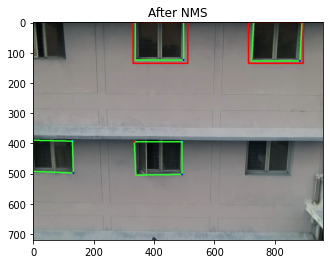

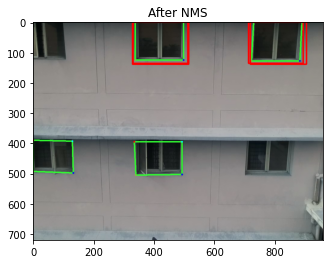

In [11]:
def nms_local(boxes_tuples, overlapThresh, i):    
    # apply non-maxima suppression to the rectangles
    pick = non_max_suppression_fast(np.array(boxes_tuples),overlapThresh)
    print("[INFO] {} matched locations *after* NMS".format(len(pick)))
    # loop over the final bounding boxes
    print(pick)
    for (sX, sY, eX, eY) in pick:
        # draw the bounding box on the image
        print('in')
        cv2.rectangle(img_copy, (sX, sY), (eX, eY),
            (255, 0, 0), 3)
    plt.figure(num = str(i) + ' ' + 'nms')
    plt.imshow(img_copy)
    plt.title("After NMS")

rects_all = np.array(rects_all)
#rects_all_array = np.reshape(rects_all, (rects_all.shape[0]*rects_all.shape[1],rects_all.shape[2]))
#print(rects_all_array)
tW_all = np.ravel(tW_all)
tH_all = np.ravel(tH_all)
    
#---------NMS after TM of all model-detected windows----------

#boxes is an array of bounding boxes each with 2 co-ordinates - (x1, y1, x2, y2)
#lower left is (x1,y1), upper right is (x2,y2)

overlapThresh = 0.25

for i in range(coords.shape[0]):
    boxes = np.array(rects_all[i])
    print(boxes)
    print(boxes.shape)

    xCoords = boxes[:,0]
    yCoords = boxes[:,1]
    xCoords2 = boxes[:,2]
    yCoords2 = boxes[:,3]

    boxes_tuples = []
    #loop over the starting (x, y)-coordinates again
    for (x, y, x2, y2) in zip(xCoords, yCoords, xCoords2, yCoords2):
        # update our list of rectangles
        boxes_tuples.append((x, y, x2, y2))

    print(boxes_tuples)

    nms_local(boxes_tuples, overlapThresh, i)